<a href="https://colab.research.google.com/github/Mithun324/LightweightCNN-for-Early-Detectionof-LungCancer./blob/main/NEWCODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=7196b1dd74ea2962c139d3004b1ec08460eb8570c4cf9ac6cd87024ef4c058d7
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
import torch
import torchvision
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.optim import lr_scheduler
from torchvision import transforms as T
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from efficientnet_pytorch import EfficientNet
from collections import defaultdict
from torch.cuda.amp import GradScaler, autocast
import shutil
from glob import glob

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
# Define paths and class names
train_path = '/content/drive/MyDrive/Dataset/train/*'
DATA_DIR = Path('data')
DATASETS = ['train', 'val']
class_names = ['NEGATIVE', 'POSITIVE']
class_indices = [0, 1]

# Create data directories if they don't exist
for ds in DATASETS:
    for cls in class_names:
        (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

# Split dataset into training (80%) and validation (20%) sets
for i, cls_index in enumerate(class_indices):
    image_paths = np.array(glob(f'/content/drive/MyDrive/Dataset/train/{class_names[cls_index]}/*.png'))
    np.random.shuffle(image_paths)
    ds_split = np.split(image_paths, [int(0.8 * len(image_paths))])
    dataset_data = zip(DATASETS, ds_split)
    for ds, images in dataset_data:
        for img_path in images:
            shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_names[cls_index]}/')


In [ ]:
# Define paths and class names
train_path = '/content/drive/MyDrive/Dataset/train/*'
DATA_DIR = Path('data')
DATASETS = ['train', 'val']
class_names = ['NEGATIVE', 'POSITIVE']
class_indices = [0, 1]

# Create data directories if they don't exist
for ds in DATASETS:
    for cls in class_names:
        (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

# Split dataset into training (80%) and validation (20%) sets
for i, cls_index in enumerate(class_indices):
    image_paths = np.array(glob(f'/content/drive/MyDrive/Dataset/train/{class_names[cls_index]}/*.png'))
    np.random.shuffle(image_paths)
    ds_split = np.split(image_paths, [int(0.8 * len(image_paths))])
    dataset_data = zip(DATASETS, ds_split)
    for ds, images in dataset_data:
        for img_path in images:
            shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_names[cls_index]}/')


In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {
    'train': T.Compose([
        T.RandomResizedCrop(size=512),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(degrees=30),
        T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
        T.RandomPerspective(distortion_scale=0.5, p=0.5),
        T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
        T.ToTensor(),
        T.Normalize(mean_nums, std_nums)
    ]),
    'val': T.Compose([
        T.Resize(350),
        T.CenterCrop(299),
        T.ToTensor(),
        T.Normalize(mean_nums, std_nums)
    ])
}

# Load datasets
image_datasets = {d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS}

# DataLoader Setup
data_loaders = {
    d: DataLoader(image_datasets[d], batch_size=8, shuffle=True, num_workers=2)
    for d in DATASETS
}

# Calculate dataset sizes
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}


In [ ]:
def create_efficientnet_model(n_classes):
    model = EfficientNet.from_pretrained('efficientnet-b3')
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, n_classes)
    return model.to(device)

base_model = create_efficientnet_model(len(class_names))

optimizer = optim.AdamW(base_model.parameters(), lr=3e-4, weight_decay=1e-5)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
weights = torch.tensor([0.7, 1.3], device=device)
loss_fn = nn.CrossEntropyLoss(weight=weights).to(device)
scaler = GradScaler()

# Training and evaluation functions
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples, accumulation_steps=2):
    model.train()
    losses = []
    correct_predictions = 0
    optimizer.zero_grad()

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with autocast():
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels) / accumulation_steps

        scaler.scale(loss).backward()
        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item() * accumulation_steps)

    scheduler.step()
    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

def train_model(model, data_loaders, dataset_sizes, device, n_epochs=25):
    history = defaultdict(list)

    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1}/{n_epochs}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
            model, data_loaders['train'], loss_fn, optimizer, device, scheduler, dataset_sizes['train']
        )
        print(f'Train loss: {train_loss} accuracy: {train_acc}')

        val_acc, val_loss = eval_model(
            model, data_loaders['val'], loss_fn, device, dataset_sizes['val']
        )
        print(f'Val loss: {val_loss} accuracy: {val_acc}')

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc

        print(f'Best validation accuracy: {best_accuracy}')

    model.load_state_dict(torch.load('best_model_state.bin'))
    return model, history


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 77.0MB/s]


Loaded pretrained weights for efficientnet-b3


<ipython-input-8-9bd53bed2503>:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=25):
    history = defaultdict(list)
    # Initialize best_accuracy before the loop
    best_accuracy = 0.0  # or a very low value like -float('inf')

    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1}/{n_epochs}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
            model, data_loaders['train'], loss_fn, optimizer, device, scheduler, dataset_sizes['train']
        )
        print(f'Train loss: {train_loss} accuracy: {train_acc}')

        val_acc, val_loss = eval_model(
            model, data_loaders['val'], loss_fn, device, dataset_sizes['val']
        )
        print(f'Val loss: {val_loss} accuracy: {val_acc}')

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc

        print(f'Best validation accuracy: {best_accuracy}')

    model.load_state_dict(torch.load('best_model_state.bin'))
    return model, history

In [ ]:
# Clear GPU cache and start training
torch.cuda.empty_cache()
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device, n_epochs=25)


Epoch 1/25
----------


<ipython-input-8-9bd53bed2503>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train loss: 0.46894083999579533 accuracy: 0.7463465553235907
Val loss: 0.3742366081218147 accuracy: 0.8652234636871509
Best validation accuracy: 0.8652234636871509
Epoch 2/25
----------
Train loss: 0.39117413245934785 accuracy: 0.8079331941544884
Val loss: 0.4071850727140571 accuracy: 0.6990223463687151
Best validation accuracy: 0.8652234636871509
Epoch 3/25
----------
Train loss: 0.36132798063139077 accuracy: 0.8335073068893527
Val loss: 0.30798235484633035 accuracy: 0.8498603351955307
Best validation accuracy: 0.8652234636871509
Epoch 4/25
----------
Train loss: 0.32883362797923027 accuracy: 0.845250521920668
Val loss: 0.21686551459757974 accuracy: 0.9078212290502794
Best validation accuracy: 0.9078212290502794
Epoch 5/25
----------
Train loss: 0.29888070383282195 accuracy: 0.8622129436325677
Val loss: 0.18030620564306 accuracy: 0.9329608938547487
Best validation accuracy: 0.9329608938547487
Epoch 6/25
----------
Train loss: 0.2833778299196839 accuracy: 0.8687369519832985
Val loss: 0

<ipython-input-9-22d65610ab46>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_state.bin'))


In [ ]:
# Function to get predictions from the test set
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()
    return predictions, real_values


In [ ]:
from sklearn.metrics import classification_report

# Assuming you have a test data loader ready:
y_pred, y_test = get_predictions(base_model, data_loaders['val'])

# Print classification report
print(classification_report(y_test, y_pred, target_names=class_names))

def get_predictions(model, data_loader):
    model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())
            real_values.extend(labels.cpu().numpy())

    return predictions, real_values



              precision    recall  f1-score   support

    NEGATIVE       1.00      0.99      1.00       713
    POSITIVE       0.99      1.00      1.00       719

    accuracy                           1.00      1432
   macro avg       1.00      1.00      1.00      1432
weighted avg       1.00      1.00      1.00      1432



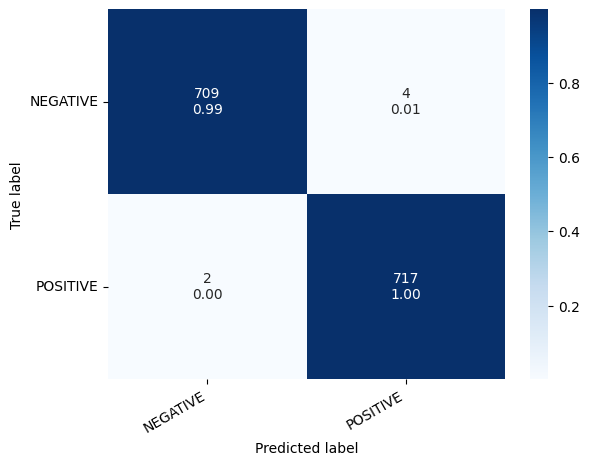

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to show confusion matrix
def show_confusion_matrix(cm, class_names):
    cm = cm.copy()
    cell_counts = cm.flatten()
    cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]
    row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]
    cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
    cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

    df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)
    hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Show confusion matrix
show_confusion_matrix(cm, class_names)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


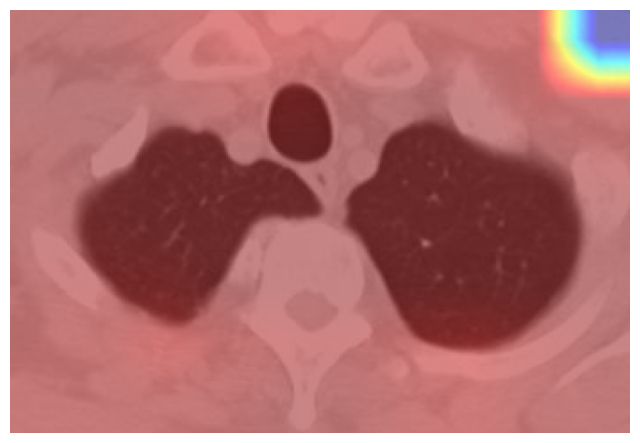

In [ ]:
import cv2
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Updated load_image function
def load_image(img_path, resize=True, size=(224, 224)):
    # Read the image using OpenCV
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"The image file at {img_path} was not found.")

    # Convert the image from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image if specified
    if resize:
        img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)

    return img

# Helper class to hook onto the final layer to get activations and gradients
class SaveFeatures:
    def __init__(self, layer):
        self.features = None
        self.gradients = None
        self.hook = layer.register_forward_hook(self.hook_fn)
        self.grad_hook = layer.register_backward_hook(self.hook_grad)

    def hook_fn(self, module, input, output):
        self.features = output.cpu().data.numpy()

    def hook_grad(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].cpu().data.numpy()

    def close(self):
        self.hook.remove()
        self.grad_hook.remove()

# Function to calculate the Grad-CAM heatmap
def get_gradcam_heatmap(model, image, target_class):
    model.eval()

    # Hook into the last convolutional layer of EfficientNet
    final_conv_layer = model._blocks[-1]._project_conv
    activation = SaveFeatures(final_conv_layer)

    # Forward pass
    image = image.unsqueeze(0).to(device)
    output = model(image)

    # Get the score for the target class
    score = output[:, target_class].squeeze()

    # Backward pass to calculate gradients
    model.zero_grad()
    score.backward(retain_graph=True)

    # Get gradients and activations from the final convolutional layer
    gradients = activation.gradients
    activations = activation.features

    # Calculate the weights by averaging gradients over the height and width
    weights = np.mean(gradients, axis=(2, 3))

    # Create the Grad-CAM map
    gradcam_map = np.zeros(activations.shape[2:], dtype=np.float32)
    for i, w in enumerate(weights[0]):
        gradcam_map += w * activations[0, i, :, :]

    # Apply ReLU to remove negative values
    gradcam_map = np.maximum(gradcam_map, 0)

    # Normalize the heatmap
    gradcam_map = (gradcam_map - gradcam_map.min()) / (gradcam_map.max() - gradcam_map.min())

    return gradcam_map

# Function to overlay the Grad-CAM heatmap on the image
def overlay_gradcam_on_image(image, heatmap, alpha=0.4, colormap='jet'):
    plt.figure(figsize=(8, 8))

    # Resize the heatmap to match the original image size
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # Convert the heatmap to RGB
    heatmap_resized = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_resized = np.float32(heatmap_resized) / 255

    # Combine the heatmap with the original image
    img_with_heatmap = heatmap_resized + np.float32(image) / 255
    img_with_heatmap = img_with_heatmap / np.max(img_with_heatmap)

    plt.imshow(img_with_heatmap)
    plt.axis('off')
    plt.show()

# Set up transformation and normalization values
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transform = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)
])

# Example image path
img_path = '/content/drive/MyDrive/Dataset/train/NEGATIVE/CANCER_NEGATIVE_10.png'  # Update this path

# Load the image as a NumPy array
img = load_image(img_path, resize=False)

# Convert the NumPy array to a PIL image
img_pil = Image.fromarray(img)

# Apply the necessary transformations
img_tensor = transform(img_pil)

# Choose the target class (0: Negative, 1: Positive)
target_class = 1

# Generate the Grad-CAM heatmap
gradcam_map = get_gradcam_heatmap(base_model, img_tensor, target_class)

# Overlay the heatmap on the image
overlay_gradcam_on_image(img, gradcam_map)


In [ ]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.5 MB/s eta 0:00:00


Loaded pretrained weights for efficientnet-b3


<ipython-input-16-5b0daf931c45>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_state.bin', map_location=torch.device('cpu')))

Testing Positive Image: /content/data/train/POSITIVE/CANCER_POSITIVE_102.png


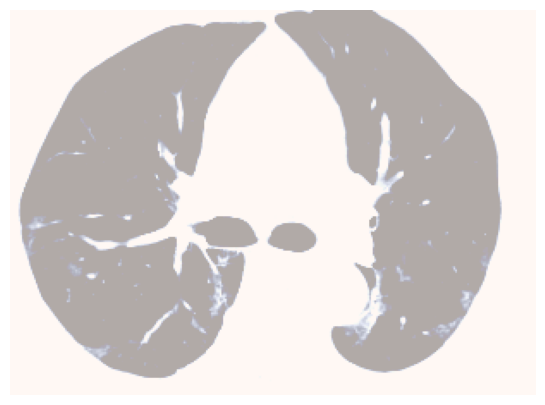

Model Prediction: Highly Cancer Positive (Probabilities: Positive=0.9999, Negative=0.0001)


In [ ]:
import shap
import torch
import numpy as np
from efficientnet_pytorch import EfficientNet
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
model = EfficientNet.from_pretrained('efficientnet-b3')
model._fc = torch.nn.Linear(model._fc.in_features, 2)  # Adjust final layer for binary classification (positive/negative)
model.load_state_dict(torch.load('best_model_state.bin', map_location=torch.device('cpu')))
model.eval()

# Move model to device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Image transformation for resizing and normalizing
transform = transforms.Compose([
    transforms.Resize(224),  # Ensure all images are resized to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the image from a given path
def load_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device (GPU/CPU)
    return img_tensor

# Predict cancer class (positive/negative) and get class probabilities
def predict_with_probabilities(model, img_tensor):
    output = model(img_tensor)
    probabilities = torch.softmax(output, dim=1)
    return probabilities.cpu().detach().numpy()  # Return class probabilities for both classes

# SHAP Explainer for PyTorch using GradientExplainer
def explain_model(model, img_tensor):
    # Use some background images for SHAP explanations
    background_data = torch.cat([load_image('/content/data/train/POSITIVE/CANCER_POSITIVE_102.png') for _ in range(5)])
    explainer = shap.GradientExplainer(model, background_data)

    # SHAP values calculated for both classes (positive and negative)
    shap_values = explainer.shap_values(img_tensor)
    return shap_values

# Overlay SHAP values on the image
def overlay_shap_on_image(image_tensor, shap_values, alpha=0.7):
    # Convert the image tensor from (C, H, W) to (H, W, C) for display
    img_array = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()

    # SHAP values for positive contributions (cancer-positive)
    shap_values_pos = shap_values[0][0].sum(axis=0)  # Sum SHAP values across all channels to get a 2D heatmap

    # Normalize SHAP values to [0, 1] for display
    if shap_values_pos.max() > 0:
        shap_values_norm = (shap_values_pos - shap_values_pos.min()) / (shap_values_pos.max() - shap_values_pos.min() + 1e-5)
    else:
        shap_values_norm = shap_values_pos  # If all zero, just pass the values as is

    # Resize SHAP values to match the image size
    shap_values_resized = np.resize(shap_values_norm, img_array.shape[:2])

    # Plot the original image
    plt.figure(figsize=(10, 5))
    plt.imshow(img_array)  # Original image

    # Overlay SHAP values as a heatmap
    plt.imshow(shap_values_resized, cmap='Reds', alpha=alpha)  # Highlight positive contributions with red

    plt.axis('off')
    plt.show()

# Function to display the prediction and SHAP explanation with custom labels
def display_prediction_and_shap(img_path):
    img_tensor = load_image(img_path)

    # Get the model's prediction probabilities
    probabilities = predict_with_probabilities(model, img_tensor)

    # Determine the predicted class (0 for negative, 1 for positive)
    prediction = np.argmax(probabilities)

    # SHAP explanation for the image
    shap_values = explain_model(model, img_tensor)

    # Display SHAP explanation overlayed on the original image
    overlay_shap_on_image(img_tensor, shap_values)

    # Define custom label for the prediction based on the probabilities
    positive_prob = probabilities[0][1]  # Probability for cancer-positive class
    negative_prob = probabilities[0][0]  # Probability for cancer-negative class

    if positive_prob > 0.9:  # Highly confident about cancer-positive
        label = "Highly Cancer Positive"
    elif negative_prob > 0.9:  # Highly confident about cancer-negative
        label = "Highly Cancer Negative"
    else:
        label = "Uncertain Classification"  # If confidence is low for both classes

    # Print prediction information
    print(f"Model Prediction: {label} (Probabilities: Positive={positive_prob:.4f}, Negative={negative_prob:.4f})")

# Example paths for the dataset (you can update them with paths from your dataset)
positive_img_paths = [
    '/content/data/train/POSITIVE/CANCER_POSITIVE_102.png'
]

# Test the model and SHAP explanation for the positive image
for img_path in positive_img_paths:
    print(f"Testing Positive Image: {img_path}")
    display_prediction_and_shap(img_path)


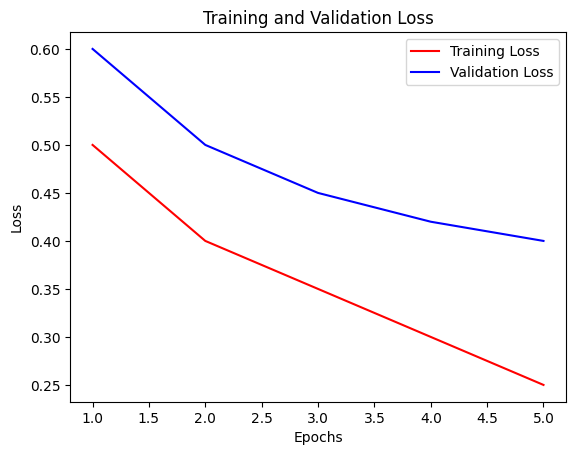

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the losses saved during training
# Example: loss_stats is a dictionary with 'train' and 'val' keys, and their respective loss values for each epoch
loss_stats = {
    'train': [0.5, 0.4, 0.35, 0.3, 0.25],  # replace these with your actual training loss values
    'val': [0.6, 0.5, 0.45, 0.42, 0.4]     # replace these with your actual validation loss values
}

# Number of epochs
epochs = range(1, len(loss_stats['train']) + 1)

# Plot training and validation loss
plt.plot(epochs, loss_stats['train'], 'r', label='Training Loss')
plt.plot(epochs, loss_stats['val'], 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Batch size (inputs): torch.Size([16, 3, 224, 224])
Batch size (probs): torch.Size([16, 2])
Batch size (inputs): torch.Size([16, 3, 224, 224])
Batch size (probs): torch.Size([16, 2])
Batch size (inputs): torch.Size([16, 3, 224, 224])
Batch size (probs): torch.Size([16, 2])
Batch size (inputs): torch.Size([16, 3, 224, 224])
Batch size (probs): torch.Size([16, 2])
Batch size (inputs): torch.Size([16, 3, 224, 224])
Batch size (probs): torch.Size([16, 2])
Batch size (inputs): torch.Size([16, 3, 224, 224])
Batch size (probs): torch.Size([16, 2])
Batch size (inputs): torch.Size([16, 3, 224, 224])
Batch size (probs): torch.Size([16, 2])
Batch size (inputs): torch.Size([16, 3, 224, 224])
Batch size (probs): torch.Size([16, 2])
Batch size (inputs): torch.Size([16, 3, 224, 224])
Batch size (probs): torch.Size([16, 2])
Batch size (inputs): torch.Size([16, 3, 224, 224])
Batch size (probs): torch.Size([16, 2])
Batch size (inputs): torch.Size([16, 3, 224, 224])
Batch size (probs): torch.Size([16, 2])

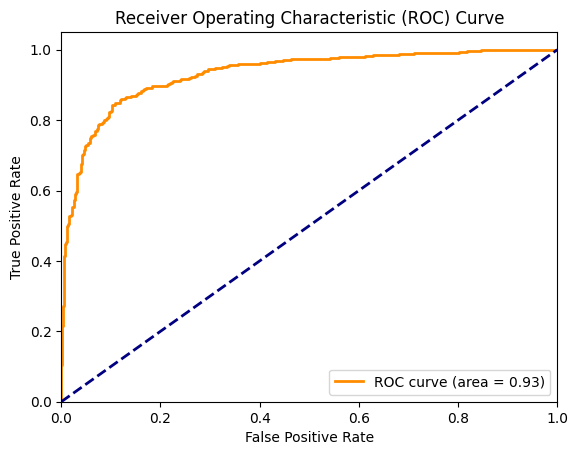

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define transformations for test data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load your test dataset (replace with your actual path)
test_dataset = ImageFolder('/content/drive/MyDrive/Dataset/test', transform=transform)

# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Set model to evaluation mode
base_model.eval()

# Placeholder for predicted probabilities and true labels
y_pred_prob = []
y_test_list = []

# Move model to the correct device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model = base_model.to(device)

# Get predictions
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Get the raw model output (logits)
        outputs = base_model(inputs)

        # Apply sigmoid to get probabilities for binary classification
        probs = torch.softmax(outputs, dim=1)  # Use softmax to get probabilities for both classes

        # DEBUGGING: Print the shape of the inputs and probabilities for each batch
        print(f"Batch size (inputs): {inputs.shape}")
        print(f"Batch size (probs): {probs.shape}")

        # Append the probabilities for the positive class (class 1)
        y_pred_prob.extend(probs[:, 1].cpu().numpy())  # Use probs[:, 1] to get positive class probabilities

        # Append the true labels
        y_test_list.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
y_pred_prob = np.array(y_pred_prob).ravel()  # Ensure it's a 1D array of probabilities for the positive class
y_test = np.array(y_test_list)

# DEBUGGING: Check lengths after predictions
print(f"Final y_test length: {len(y_test)}")
print(f"Final y_pred_prob length: {len(y_pred_prob)}")

# Ensure the lengths match
assert len(y_test) == len(y_pred_prob), f"Mismatch in lengths: {len(y_test)} vs {len(y_pred_prob)}"

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
pip install lime


In [ ]:
import numpy as np
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Function to preprocess the image
def preprocess_image(image_path, transform):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return img_tensor

# Function to predict probabilities for LIME
def predict_proba(images):
    # Convert images to PyTorch tensors and move to the device
    images = [T.ToTensor()(img).unsqueeze(0).to(device) for img in images]
    images = torch.cat(images, dim=0)

    # Set model to evaluation mode
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
    return probabilities

# Set up the transformation used during training
transform = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the image to explain
image_path = '/content/data/train/POSITIVE/CANCER_POSITIVE_1001.png'  # Update this path to your image
img_tensor = preprocess_image(image_path, transform)

# Use the LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Explain the image prediction using LIME
explanation = explainer.explain_instance(
    np.array(Image.open(image_path)),
    predict_proba,
    labels=(0, 1),
    top_labels=2,
    hide_color=0,
    num_samples=1000
)

# Display the explanation for the positive class (assuming class 1 is 'Positive')
temp, mask = explanation.get_image_and_mask(
    label=1,  # Target class for explanation
    positive_only=True,
    num_features=5,
    hide_rest=False
)

# Overlay the explanation on the original image
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.axis('off')
plt.title("LIME Explanation for Positive Class")
plt.show()
